# 02 Synology C2 Exploratory Analysis

Objective 2 focuses on profiling C2 adoption by region, customer tier, and SKU while preparing the dataset that will underpin the `analytics.c2_adoption_scorecard` table.


## Analysis Checklist

- Verify C2 records in the cleaned sales snapshot.
- Segment results by service family, plan variant, region, and derived customer tiers.
- Produce a monthly scorecard aligned with the warehouse schema and save it for review.


In [ ]:
import os
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

pd.set_option("display.max_columns", 60)
pd.set_option("display.width", 180)


In [2]:
def find_project_root(start: Path) -> Path:
    for candidate in [start, *start.parents]:
        if (candidate / "data" / "processed").exists() and (candidate / "src").exists():
            return candidate
    return start

NOTEBOOK_ROOT = Path.cwd().resolve()
PROJECT_ROOT = Path(os.environ.get("SYNOBI_REPO_ROOT", find_project_root(NOTEBOOK_ROOT)))
DATA_PATH = PROJECT_ROOT / "data" / "processed" / "synosales_cleaned.parquet"
OUTPUT_DIR = PROJECT_ROOT / "notebook_outputs"
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

DATA_PATH


PosixPath('/Volumes/docker/syno_bi/repo/data/processed/synosales_cleaned.parquet')

In [3]:
raw_sales = pd.read_parquet(DATA_PATH)
raw_sales.columns = raw_sales.columns.str.strip()

print(f"Loaded {len(raw_sales):,} rows from {DATA_PATH}")
raw_sales.head()


Loaded 205,708 rows from /Volumes/docker/syno_bi/repo/data/processed/synosales_cleaned.parquet


,PI,Customer,ItemCode,Product,source_sheet,Quantity,usd_adjusted_price,usd_adjusted_total,InvDate,Country,Type,sub_cat,Year,Region
0,2364503.0,C2,C2 Storage Advanced,C2 Storage Advanced,2023-C2,1,109.9245,109.9245,2023-01-01,Andorra,C2-HYBRID,C2-STORAGE-UNKNOWN-ADVANCED,2023,FR
1,2364504.0,C2,C2 Storage Basic,C2 Storage Basic,2023-C2,1,37.0965,37.0965,2023-01-01,Andorra,C2-HYBRID,C2-STORAGE-UNKNOWN-BASIC,2023,FR
2,2364505.0,C2,C2 Storage Basic,C2 Storage Basic,2023-C2,1,1.9600,1.9600,2023-01-01,Andorra,C2-HYBRID,C2-STORAGE-UNKNOWN-BASIC,2023,FR
3,2364506.0,C2,Active Insight Premium Early Bird,Active Insight Premium Early Bird,2023-C2,1,13.1565,13.1565,2023-01-01,United Arab Emirates,C2-HYBRID,Other,2023,HQ
4,2364507.0,C2,C2 Storage Advanced,C2 Storage Advanced,2023-C2,1,1309.3290,1309.3290,2023-01-01,United Arab Emirates,C2-HYBRID,C2-STORAGE-UNKNOWN-ADVANCED,2023,HQ


### Filter for C2 services and derive attributes

The cleaned snapshot contains all Synology sale-out activity. We focus on rows whose `sub_cat` classification starts with `C2-`, then derive reusable attributes (service family, capacity, plan variant) and a month-end snapshot key for aggregation.


In [4]:
C2_PREFIX = os.environ.get("C2_SUBCAT_PREFIX", "C2-")
subcat_series = raw_sales["sub_cat"] if "sub_cat" in raw_sales.columns else pd.Series("", index=raw_sales.index, dtype="object")
c2_mask = subcat_series.fillna("").astype(str).str.upper().str.startswith(C2_PREFIX.upper())
c2_sales = raw_sales.loc[c2_mask].copy()
c2_sales["InvDate"] = pd.to_datetime(c2_sales["InvDate"], errors="coerce")
c2_sales = c2_sales.dropna(subset=["InvDate"]).reset_index(drop=True)
print(f"Filtered C2 cohort to {len(c2_sales):,} rows across {c2_sales['Customer'].nunique()} customers")

def parse_c2_components(value: str) -> tuple[str, str, str]:
    tokens = str(value or "").upper().split("-")
    if len(tokens) < 4:
        tokens = tokens + ["UNKNOWN"] * (4 - len(tokens))
    return tokens[1], tokens[2], tokens[3]

components = c2_sales["sub_cat"].apply(parse_c2_components)
c2_sales["service_family"] = components.apply(lambda tpl: tpl[0])
c2_sales["capacity_band"] = components.apply(lambda tpl: tpl[1])
c2_sales["plan_variant"] = components.apply(lambda tpl: tpl[2])
c2_sales["snapshot_month"] = c2_sales["InvDate"].dt.to_period("M").dt.to_timestamp("M")
c2_sales[["Customer", "Product", "service_family", "capacity_band", "plan_variant"]].head()


Filtered C2 cohort to 24,187 rows across 19 customers


,Customer,Product,service_family,capacity_band,plan_variant
0,C2,C2 Storage Advanced,STORAGE,UNKNOWN,ADVANCED
1,C2,C2 Storage Basic,STORAGE,UNKNOWN,BASIC
2,C2,C2 Storage Basic,STORAGE,UNKNOWN,BASIC
3,C2,C2 Storage Advanced,STORAGE,UNKNOWN,ADVANCED
4,C2,C2 Storage Basic,STORAGE,UNKNOWN,BASIC


In [5]:
service_summary = (
    c2_sales.groupby(["service_family", "plan_variant"], dropna=False)
    .agg(
        total_revenue=("usd_adjusted_total", "sum"),
        total_quantity=("Quantity", "sum"),
        customer_count=("Customer", "nunique"),
        sku_count=("ItemCode", "nunique"),
    )
    .sort_values("total_revenue", ascending=False)
)
service_summary.head(10)


total_revenue  total_quantity  customer_count  sku_count
service_family plan_variant                                                          
STORAGE        ADVANCED       5.095962e+07         1485284               4         12
               UNKNOWN        9.668694e+06          312941               6          4
               BASIC          6.051871e+06          145005               4         19
BACKUP         UNKNOWN        2.271969e+06           77385              15         34
               BUSINESS       2.129080e+06            2047               1          1
               INDIVIDUAL     3.853826e+05            2203               1          1
OBJECT         UNKNOWN        3.698938e+05           26662               3          9
BACKUP         ENTERPRISE     2.664229e+05            2354               3          5
IDENTITY       BUSINESS       1.476607e+05             601               1          1
               UNKNOWN        1.114189e+05           24759               3          8

In [6]:
customer_revenue = (
    c2_sales.groupby("Customer", dropna=False)["usd_adjusted_total"]
    .sum()
    .sort_values(ascending=False)
)

if customer_revenue.empty:
    tier_lookup = pd.DataFrame(columns=["Customer", "customer_tier"])
else:
    customer_revenue = customer_revenue.reset_index().rename(columns={"usd_adjusted_total": "total_revenue"})
    customer_revenue["revenue_rank"] = np.arange(1, len(customer_revenue) + 1)

    def label_tier(rank: int) -> str:
        if rank <= 5:
            return "Tier 1 - Top 5"
        if rank <= 20:
            return "Tier 2 - Top 20"
        return "Tier 3 - Long Tail"

    customer_revenue["customer_tier"] = customer_revenue["revenue_rank"].apply(label_tier)
    tier_lookup = customer_revenue[["Customer", "customer_tier"]]

tier_lookup.head(10)


,Customer,customer_tier
0,C2,Tier 1 - Top 5
1,Synology GmbH,Tier 1 - Top 5
2,C2_USA,Tier 1 - Top 5
3,Partner channel_TW,Tier 1 - Top 5
4,C2 台灣,Tier 1 - Top 5
5,Partner channel,Tier 2 - Top 20
6,Apple_C2,Tier 2 - Top 20
7,LASTING System,Tier 2 - Top 20
8,Ablestor,Tier 2 - Top 20
9,Ingram Micro,Tier 2 - Top 20


In [7]:
scorecard = c2_sales.merge(tier_lookup, on="Customer", how="left")
scorecard["customer_tier"] = scorecard["customer_tier"].fillna("Tier 3 - Long Tail")
if "Region" in scorecard.columns:
    scorecard["region"] = scorecard["Region"].fillna("Unknown")
else:
    scorecard["region"] = "Unknown"
if "PI" not in scorecard.columns:
    scorecard["PI"] = scorecard.index.map(lambda idx: f"order_{idx}")

scorecard["Quantity"] = pd.to_numeric(scorecard.get("Quantity"), errors="coerce").fillna(0)
scorecard["usd_adjusted_total"] = pd.to_numeric(scorecard.get("usd_adjusted_total"), errors="coerce").fillna(0.0)

scorecard_agg = (
    scorecard.groupby(
        ["snapshot_month", "service_family", "plan_variant", "region", "customer_tier"],
        dropna=False,
    )
    .agg(
        active_subscriptions=("Customer", "nunique"),
        new_subscriptions=("PI", "nunique"),
        total_quantity=("Quantity", "sum"),
        arr_usd=("usd_adjusted_total", "sum"),
    )
    .reset_index()
)

scorecard_agg["sku"] = "ALL"
scorecard_agg["avg_seats"] = scorecard_agg["total_quantity"] / scorecard_agg["active_subscriptions"].replace(0, np.nan)
scorecard_agg = scorecard_agg[
    [
        "snapshot_month",
        "service_family",
        "plan_variant",
        "region",
        "customer_tier",
        "sku",
        "active_subscriptions",
        "new_subscriptions",
        "arr_usd",
        "total_quantity",
        "avg_seats",
    ]
]
scorecard_agg.sort_values(["snapshot_month", "service_family", "region"]).head(12)


,snapshot_month,service_family,plan_variant,region,customer_tier,sku,active_subscriptions,new_subscriptions,churned_subscriptions,net_subscriptions,arr_usd,avg_seats,telemetry_uptime_pct,support_tickets,ticket_rate_per_100_accounts
0,2023-01-31,BACKUP,BUSINESS,DE,Tier 1 - Top 5,ALL,1,13,NaN,1,6798.661000,13.0,NaN,NaN,NaN
6,2023-01-31,BACKUP,ENTERPRISE,DE,Tier 1 - Top 5,ALL,2,4,NaN,2,5828.267500,35.0,NaN,NaN,NaN
9,2023-01-31,BACKUP,INDIVIDUAL,DE,Tier 1 - Top 5,ALL,1,17,NaN,1,2941.440500,17.0,NaN,NaN,NaN
15,2023-01-31,BACKUP,UNKNOWN,DE,Tier 1 - Top 5,ALL,1,2,NaN,1,20835.208500,832.0,NaN,NaN,NaN
1,2023-01-31,BACKUP,BUSINESS,FR,Tier 1 - Top 5,ALL,1,12,NaN,1,8122.390500,12.0,NaN,NaN,NaN
10,2023-01-31,BACKUP,INDIVIDUAL,FR,Tier 1 - Top 5,ALL,1,9,NaN,1,1787.646000,9.0,NaN,NaN,NaN
2,2023-01-31,BACKUP,BUSINESS,HQ,Tier 1 - Top 5,ALL,1,17,NaN,1,3885.131626,17.0,NaN,NaN,NaN
11,2023-01-31,BACKUP,INDIVIDUAL,HQ,Tier 1 - Top 5,ALL,1,24,NaN,1,1312.250870,24.0,NaN,NaN,NaN
3,2023-01-31,BACKUP,BUSINESS,JP,Tier 1 - Top 5,ALL,1,1,NaN,1,51.650000,1.0,NaN,NaN,NaN
12,2023-01-31,BACKUP,INDIVIDUAL,JP,Tier 1 - Top 5,ALL,1,2,NaN,1,45.820000,2.0,NaN,NaN,NaN


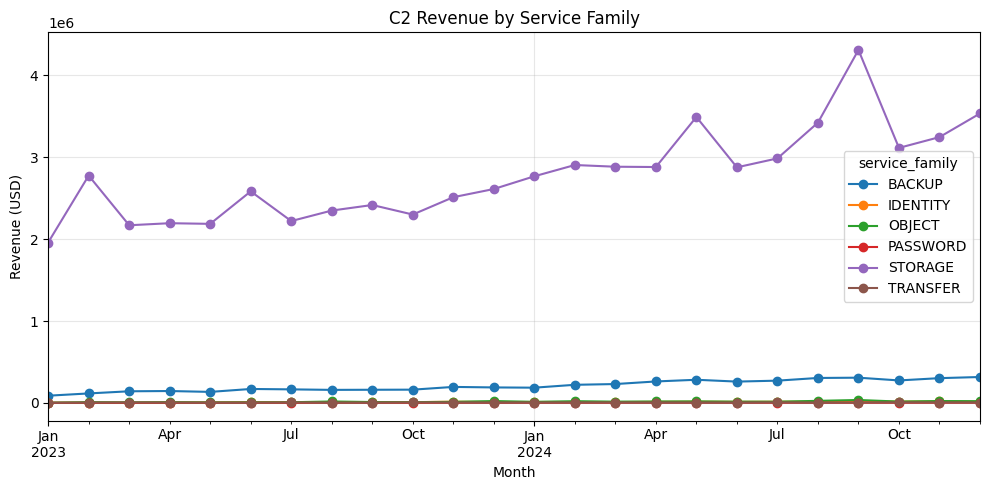

In [8]:
monthly_revenue = (
    scorecard_agg.groupby(["snapshot_month", "service_family"], dropna=False)["arr_usd"].sum()
    .unstack(fill_value=0)
    .sort_index()
)
ax = monthly_revenue.plot(kind="line", figsize=(10, 5), marker="o")
ax.set_title("C2 Revenue by Service Family")
ax.set_xlabel("Month")
ax.set_ylabel("Revenue (USD)")
ax.grid(True, alpha=0.3)
plt.tight_layout()


In [9]:
scorecard_path = OUTPUT_DIR / "c2_adoption_scorecard.csv"
scorecard_agg.to_csv(scorecard_path, index=False)
print(f"Saved scorecard extract to {scorecard_path}")
scorecard_path


Saved scorecard extract to /Volumes/docker/syno_bi/repo/notebook_outputs/c2_adoption_scorecard.csv


PosixPath('/Volumes/docker/syno_bi/repo/notebook_outputs/c2_adoption_scorecard.csv')

### Next Steps

- Validate the scorecard definitions (especially churn, telemetry, and support placeholders) with the C2 business owners.
- Promote the transformation into a reusable pipeline/dbt model once metric definitions are ratified.
- Incorporate telemetry and support touch integrations so the placeholder fields can be populated automatically.
